In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import algorithms
import evaluation

In [3]:
np.random.seed(42)

In [4]:
excel_file = 'experiments/medical/Breast_Cancer_Chemotherapy_Dataset_121515.xlsx'
sheet_1 = 'Dataset(Context,Action,Reward)'
sheet_2 = 'TransferReward'

In [5]:
print("Sheet 1:")
pd.read_excel(excel_file, sheet_name=sheet_1).head()


Sheet 1:


,Patient ID,Feature,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Action,Reward
0,NaN,Age,Menopausal,Race,Estrogen Receptor,Progesterone Receptor,HER2NUE,Tumor Stage,Tumor Grade,PLNC,Lymph Node Status,WHO Score,Surgery Type,Prior Radiotherapy,Prior Chemotherapy,Histology,NaN,NaN
1,1.0,3,2,1,2,1,1,1,2,3,2,1,2,2,1,1,2.0,0.334351
2,2.0,1,1,3,2,2,2,1,3,3,2,2,2,1,2,1,1.0,0.355958
3,3.0,3,1,1,1,1,2,2,2,3,1,1,1,2,2,1,2.0,0.394279
4,4.0,2,1,1,2,2,1,2,3,1,1,1,2,1,2,1,1.0,0.773465


In [6]:
print("Sheet 2:")
pd.read_excel(excel_file, sheet_name=sheet_2).head()

Sheet 2:


,Unnamed: 0,Transfer Reward (Normalized),Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Patient ID,Chemo 1,Chemo 2,Chemo 3,Chemo 4,Chemo 5,Chemo 6
1,1,0.132838,0.334351,0.054796,0.037213,0.054395,0.110552
2,2,0.355958,0.337438,0.028174,0.007678,0.151268,0.237898
3,3,0.287652,0.394279,0.027879,0.066609,0.031137,0.059067
4,4,0.773465,0.275363,0.02762,0.004676,0.232115,0.25493


In [7]:
cols2skip_c = [0,16,17]
cols2skip_tr = [0]
context_index = [i for i in range(18) if i not in cols2skip_c]
tranfer_reward_index = [i for i in range(6) if i not in cols2skip_tr]

data_context = pd.read_excel(excel_file, sheet_name=sheet_1, header=None, skiprows=2, usecols=context_index)
data_transfer_rewards = pd.read_excel(
    excel_file, sheet_name=sheet_2, header=None, skiprows=2, usecols=tranfer_reward_index
)

data = pd.read_excel(excel_file)

In [8]:
data

,Patient ID,Feature,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Action,Reward
0,NaN,Age,Menopausal,Race,Estrogen Receptor,Progesterone Receptor,HER2NUE,Tumor Stage,Tumor Grade,PLNC,Lymph Node Status,WHO Score,Surgery Type,Prior Radiotherapy,Prior Chemotherapy,Histology,NaN,NaN
1,1.0,3,2,1,2,1,1,1,2,3,2,1,2,2,1,1,2.0,0.334351
2,2.0,1,1,3,2,2,2,1,3,3,2,2,2,1,2,1,1.0,0.355958
3,3.0,3,1,1,1,1,2,2,2,3,1,1,1,2,2,1,2.0,0.394279
4,4.0,2,1,1,2,2,1,2,3,1,1,1,2,1,2,1,1.0,0.773465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,9996.0,3,1,1,2,1,1,1,2,3,1,2,1,1,2,1,2.0,0.277812
9997,9997.0,2,2,1,1,2,2,2,2,2,2,2,1,2,1,1,1.0,0.458562
9998,9998.0,4,1,2,1,1,1,2,1,2,1,3,2,1,2,2,1.0,0.385728
9999,9999.0,1,1,1,2,1,1,1,3,2,2,1,1,1,2,1,5.0,0.406130


In [9]:
print("first 5 contexts:")
data_context.head()

first 5 contexts:


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,3,2,1,2,1,1,1,2,3,2,1,2,2,1,1
1,1,1,3,2,2,2,1,3,3,2,2,2,1,2,1
2,3,1,1,1,1,2,2,2,3,1,1,1,2,2,1
3,2,1,1,2,2,1,2,3,1,1,1,2,1,2,1
4,3,1,1,2,2,0,2,1,1,1,2,1,2,1,2


In [10]:
print("first 5 rewards:")
data_transfer_rewards.head()

first 5 rewards:


,1,2,3,4,5
0,0.132838,0.334351,0.054796,0.037213,0.054395
1,0.355958,0.337438,0.028174,0.007678,0.151268
2,0.287652,0.394279,0.027879,0.066609,0.031137
3,0.773465,0.275363,0.027620,0.004676,0.232115
4,0.226727,0.276641,0.043145,0.065420,0.121219


In [11]:
#create the matrices
all_contexts = data_context.values
print("all contexts shape:" + str(all_contexts.shape))
all_rewards = data_transfer_rewards.values
print("all rewards shape:" + str(all_rewards.shape))

all contexts shape:(10000, 15)
all rewards shape:(10000, 5)


In [12]:
#Select the contexts and actions
alpha = 2 
all_contexts = all_contexts[:, [0, 3, 6, 11]]
print("all contexts shape:" + str(all_contexts.shape))
all_rewards_large = all_rewards[:, [0,1,2]]
print("all rewards large shape:" + str(all_rewards_large.shape))
all_rewards = all_rewards[:, [0, 1]]
print("all rewards shape:" + str(all_rewards.shape))

all contexts shape:(10000, 4)
all rewards large shape:(10000, 3)
all rewards shape:(10000, 2)


In [13]:
all_rewards_large

array([[0.13283783, 0.33435069, 0.0547964 ],
       [0.35595785, 0.33743778, 0.02817364],
       [0.28765227, 0.39427861, 0.02787924],
       ...,
       [0.38572802, 0.33934693, 0.03532575],
       [0.17639942, 0.30865811, 0.03973829],
       [0.07528787, 0.27973324, 0.0585417 ]])

In [14]:
#change the reward into 0 or 1
for i in range(10000):
    sorted_index = np.argsort(all_rewards_large[i,:])
    all_rewards_large[i,sorted_index[2]] = 1
    all_rewards_large[i,sorted_index[1]] = 0
    all_rewards_large[i,sorted_index[0]] = 0

In [15]:
all_rewards_large

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [16]:
#change the reward into 0 or 1
for i in range(10000):
    sorted_index = np.argsort(all_rewards[i,:])
    all_rewards[i,sorted_index[1]] = 1
    all_rewards[i,sorted_index[0]] = 0

In [17]:
all_rewards

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [18]:
print("all contexts shape:" + str(all_contexts.shape))
print("all rewards shape:" + str(all_rewards.shape))
all_rewards[300,:]

all contexts shape:(10000, 4)
all rewards shape:(10000, 2)


array([0., 1.])

In [19]:
all_contexts

array([[3, 2, 1, 2],
       [1, 2, 1, 2],
       [3, 1, 2, 1],
       ...,
       [4, 1, 2, 2],
       [1, 2, 1, 1],
       [4, 2, 3, 1]])

In [20]:
all_rewards

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

### Fixed costs

In [21]:
costs_vector = np.zeros(all_contexts.shape)
for i in range(all_contexts.shape[0]):
    costs_vector[i, :] = np.array([0.01]*all_contexts.shape[1])

costs_vector.shape

(10000, 4)

## Checking for non-stationarity

We check for non-stationarity by moving a sliding window over the dataset and fitting a separate logistic regression model for each arm. This gives an array of parameters for each arm, which we plot to see if they change significantly

In [23]:
WINDOW_SIZE = 1000

In [24]:
all_rewards.shape

(10000, 2)

In [25]:
from sklearn.linear_model import LogisticRegression, LinearRegression

arm_parameters = {}

for a in range(all_rewards.shape[1]):
    arm_parameters[a] = np.zeros((all_contexts.shape[0]-WINDOW_SIZE, all_contexts.shape[1]))
    for i in range(0, all_contexts.shape[0] - WINDOW_SIZE):
        window_contexts = all_contexts[i:i+WINDOW_SIZE, :]
        window_rewards = all_rewards[i:i+WINDOW_SIZE, a]
        clf = LogisticRegression().fit(window_contexts, window_rewards)
        arm_parameters[a][i, :] = clf.coef_

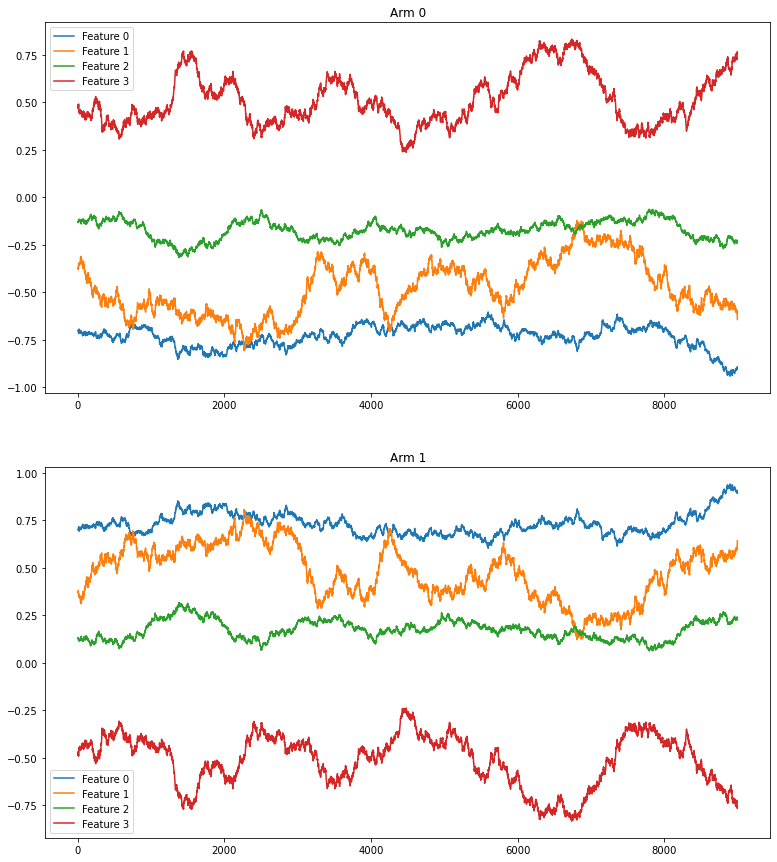

In [26]:
fig, axs = plt.subplots(len(arm_parameters), 1, figsize=(13, 15))

for a in arm_parameters:
    ax = axs[a]
    param_matrix = arm_parameters[a]
    for feat in range(param_matrix.shape[1]):
        ax.plot(param_matrix[:, feat], label=f"Feature {feat}")
        
    ax.set_title(f"Arm {a}")
    ax.legend()
        
plt.show()

$E[r | x]$ 
\
$E[r]$

In [27]:
len(arm_parameters)

2

In [28]:
clf = LogisticRegression(random_state=42).fit(all_contexts, all_rewards[:, 0])

In [29]:
clf.coef_

array([[-0.73640947, -0.47947979, -0.17766745,  0.53832573]])

In [30]:
clf = LogisticRegression(random_state=42).fit(all_contexts, all_rewards[:, 1])

In [31]:
clf.coef_

array([[ 0.73640947,  0.47947979,  0.17766745, -0.53832573]])

## Algorithm evaluation

In [32]:
NUM_OF_TRIALS = 10000

In [33]:
np.random.seed(42)

In [34]:
p_random = algorithms.RandomPolicy()
gain_random = evaluation.evaluate_on_synthetic_data(
    p_random,
    all_contexts,
    all_rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

Random policy
Total gain: 5021.0
	Total reward: 5021.0
	Total cost: 0
Execution time: 0.1s


In [35]:
egreedy = algorithms.EpsilonGreedy(epsilon=0.1, n_arms=all_rewards.shape[1])

gain_egreedy = evaluation.evaluate_on_synthetic_data(
    egreedy,
    all_contexts,
    all_rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

E-greedy(epsilon=0.1)
Total gain: 5908.0
	Total reward: 5908.0
	Total cost: 0
Execution time: 0.1s


In [36]:
ucb_alg = algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=all_rewards.shape[1],
        alpha=0.15,
    )

gain_ucb = evaluation.evaluate_on_synthetic_data(
    ucb_alg,
    all_contexts,
    all_rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

UCB1 (α=0.15)
Total gain: 5997.0
	Total reward: 5997.0
	Total cost: 0
Execution time: 0.1s


In [37]:
linucb = algorithms.LinUCB(
    context_dimension=all_contexts.shape[1],
    n_arms=all_rewards.shape[1],
    alpha=0.25,
)
gain_linucb = evaluation.evaluate_on_synthetic_data(
    linucb,
    all_contexts,
    all_rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

LinUCB (alpha=0.25)
Total gain: 6213.0000000003265
	Total reward: 6613.0
	Total cost: 400.000000000057
Execution time: 1.2s


In [38]:
ps_linucb = algorithms.PSLinUCB(
    context_dimension=all_contexts.shape[1],
    n_arms=all_rewards.shape[1],
    alpha=0.2,
    omega=250,
    delta=0.03,
)


gain_pslinucb = evaluation.evaluate_on_synthetic_data(
    ps_linucb,
    all_contexts,
    all_rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)
change_points = ps_linucb.change_points

PSLinUCB (alpha=0.2, omega=250, delta=0.03)
Total gain: 6165.0000000003265
	Total reward: 6565.0
	Total cost: 400.000000000057
Execution time: 2.1s


In [39]:
s = time.time()
p_simoos = algorithms.SimOOSAlgorithm(
    all_contexts=all_contexts, 
    number_of_actions=all_rewards.shape[1],
    max_no_red_context=all_contexts.shape[1],
    beta_SimOOS=0.2,
    delta_SimOOS=0.3,
)
print(f"Took {time.time() - s} seconds")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_simoos = evaluation.evaluate_on_synthetic_data(
        p_simoos,
        all_contexts[:NUM_OF_TRIALS],
        all_rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


Took 0.015676021575927734 seconds
Trial 0, time 2022-03-31 15:16:29.932396
Trial 500, time 2022-03-31 15:16:41.351933
Trial 1000, time 2022-03-31 15:16:41.844346
Trial 1500, time 2022-03-31 15:16:42.141108
Trial 2000, time 2022-03-31 15:16:42.483804
Trial 2500, time 2022-03-31 15:16:42.678088
Trial 3000, time 2022-03-31 15:16:42.925571
Trial 3500, time 2022-03-31 15:16:43.052636
Trial 4000, time 2022-03-31 15:16:43.306207
Trial 4500, time 2022-03-31 15:16:43.430632
Trial 5000, time 2022-03-31 15:16:43.562648
Trial 5500, time 2022-03-31 15:16:43.690153
Trial 6000, time 2022-03-31 15:16:44.069099
Trial 6500, time 2022-03-31 15:16:44.214661
Trial 7000, time 2022-03-31 15:16:44.349247
Trial 7500, time 2022-03-31 15:16:44.475797
Trial 8000, time 2022-03-31 15:16:44.617102
Trial 8500, time 2022-03-31 15:16:44.762447
Trial 9000, time 2022-03-31 15:16:44.872344
Trial 9500, time 2022-03-31 15:16:58.679748
SimOOS (beta=0.2, delta=0.3)
Total gain: 4828.079999999385
	Total reward: 5135.0
	Total co

In [40]:
s = time.time()
p_alg1 = algorithms.Algorithm1(
    all_contexts=all_contexts, 
    number_of_actions=all_rewards.shape[1],
    max_no_red_context=all_contexts.shape[1],
    beta=1.0,
    delta=0.1,
    window_length=1000,
)
print(f"Took {time.time() - s} seconds")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_alg1 = evaluation.evaluate_on_synthetic_data(
        p_alg1,
        all_contexts[:NUM_OF_TRIALS],
        all_rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


Took 0.010039806365966797 seconds
Round 500, time 2022-03-31 15:18:09.085774
Round 1000, time 2022-03-31 15:19:50.086949
Round 1500, time 2022-03-31 15:21:47.742497
Round 2000, time 2022-03-31 15:23:41.243236
Round 2500, time 2022-03-31 15:25:37.088292
Round 3000, time 2022-03-31 15:27:30.376992
Round 3500, time 2022-03-31 15:29:26.276942
Round 4000, time 2022-03-31 15:31:29.478193
Round 4500, time 2022-03-31 15:33:35.016170
Round 5000, time 2022-03-31 15:35:27.528029
Round 5500, time 2022-03-31 15:37:21.942838
Round 6000, time 2022-03-31 15:39:10.998369
Round 6500, time 2022-03-31 15:40:55.982530
Round 7000, time 2022-03-31 15:42:40.558937
Round 7500, time 2022-03-31 15:44:23.825024
Round 8000, time 2022-03-31 15:46:11.266983
Round 8500, time 2022-03-31 15:47:58.313353
Round 9000, time 2022-03-31 15:49:45.467387
Round 9500, time 2022-03-31 15:51:33.245350
Algorithm1 (beta=1.0, delta=0.1, w=1000)
Total gain: 5733.140000000007
	Total reward: 5743.0
	Total cost: 9.85999999999986
Executio

In [41]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = [1, 500, 1000]
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

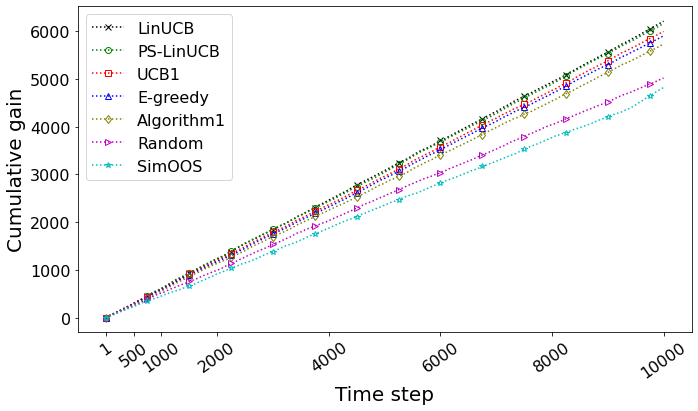

In [42]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)
